# Setup & Imports

In [1]:
# 📦 Install dependencies
# Run this cell once to make sure all required packages are available

%pip install -q pandas numpy biopython matplotlib seaborn tqdm goatools plotly umap-learn scikit-learn torch transformers


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# GO Ontology
from goatools.obo_parser import GODag


In [3]:
# Define data paths
DATA_DIR = "./cafa-6-protein-function-prediction"
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")

print("Files in Train:", os.listdir(TRAIN_DIR))
print("Files in Test:", os.listdir(TEST_DIR))


Files in Train: ['go-basic.obo', 'train_sequences.fasta', 'train_taxonomy.tsv', 'train_terms.tsv']
Files in Test: ['testsuperset-taxon-list.tsv', 'testsuperset.fasta']


# 🧠 Explore Dataset Size and Structure

- Count the number of sequences in:

    - train_sequences.fasta

    - testsuperset.fasta

- Count unique proteins in train_terms.tsv and train_taxonomy.tsv

- Check if all sequence IDs match across files.

👉 Goal: Ensure internal consistency between FASTA, taxonomy, and term mapping files.

In [4]:
# Load TSV files
train_terms = pd.read_csv(os.path.join(TRAIN_DIR, "train_terms.tsv"), sep="\t")
train_taxonomy = pd.read_csv(
    os.path.join(TRAIN_DIR, "train_taxonomy.tsv"),
    sep="\t",
    header=None,
    names=["EntryID", "Taxon"]
)

IA = pd.read_csv(
    os.path.join(DATA_DIR, "IA.tsv"),
    sep="\t",
    header=None,
    names=["GO_ID", "InformationAccretion"]
)


print("train_terms:", train_terms.shape)
print("train_taxonomy:", train_taxonomy.shape)
print("IA:", IA.shape)


train_terms: (537027, 3)
train_taxonomy: (82404, 2)
IA: (40122, 2)


In [5]:
# Preview first few rows
display(train_terms.head())
display(train_taxonomy.head())
display(IA.head())


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P


,EntryID,Taxon
0,A0A0C5B5G6,9606
1,A0JNW5,9606
2,A0JP26,9606
3,A0PK11,9606
4,A1A4S6,9606


,GO_ID,InformationAccretion
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573


## Count and Check Data Consistency

In [6]:
fasta_path = os.path.join(TRAIN_DIR, "train_sequences.fasta")
#  Unique protein IDs
def extract_uniprot_id(record_id):
    # e.g. "sp|Q9Y2Q0|ABC1_HUMAN" → "Q9Y2Q0"
    parts = record_id.split('|')
    if len(parts) >= 2:
        return parts[1]
    return record_id  # fallback if no pipe present

train_seq_ids = {extract_uniprot_id(record.id) for record in SeqIO.parse(fasta_path, "fasta")}
term_ids = set(train_terms['EntryID'])
tax_ids = set(train_taxonomy['EntryID'])

print(f"Sequences: {len(train_seq_ids)} | Terms: {len(term_ids)} | Taxonomy: {len(tax_ids)}")
print("Unmatched IDs (terms not in sequences):", len(term_ids - train_seq_ids))

Sequences: 82404 | Terms: 82404 | Taxonomy: 82404
Unmatched IDs (terms not in sequences): 0


### Sequence Length Distribution

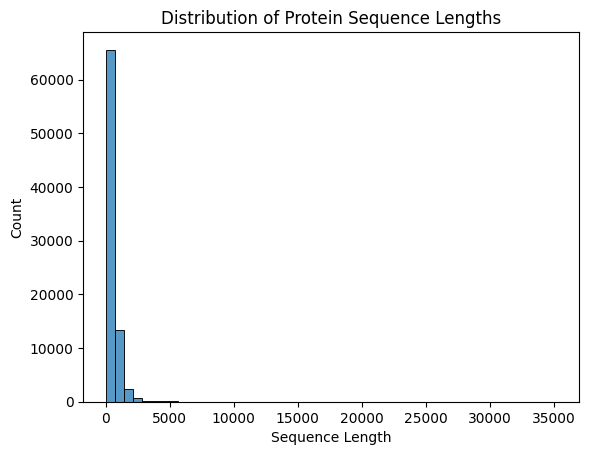

In [7]:
seq_lengths = [len(record.seq) for record in SeqIO.parse(fasta_path, "fasta")]
sns.histplot(seq_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Protein Sequence Lengths")
plt.show()


The histogram is extremely right-skewed — most proteins have short sequences (clustered near the left), and a few are very long (creating a “long tail”).

### Plotting After Remove statistical outliers

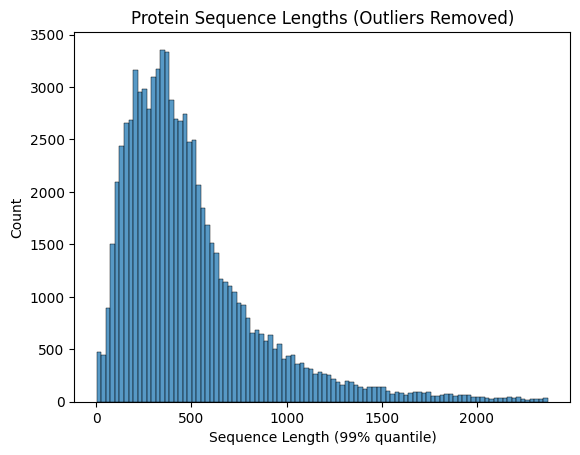

In [8]:
import numpy as np

lengths = np.array(seq_lengths)
filtered_lengths = lengths[lengths < np.percentile(lengths, 99)]  # keep 99% shortest

sns.histplot(filtered_lengths, bins=100)
plt.xlabel("Sequence Length (99% quantile)")
plt.ylabel("Count")
plt.title("Protein Sequence Lengths (Outliers Removed)")
plt.show()


### Overview for Sequence Distribution

In [9]:
print("Min length:", np.min(seq_lengths))
print("Median length:", np.median(seq_lengths))
print("Mean length:", np.mean(seq_lengths))
print("95th percentile:", np.percentile(seq_lengths, 95))
print("Max length:", np.max(seq_lengths))

Min length: 3
Median length: 409.0
Mean length: 525.7882869763604
95th percentile: 1318.0
Max length: 35213


## Number of GO Terms per Protein

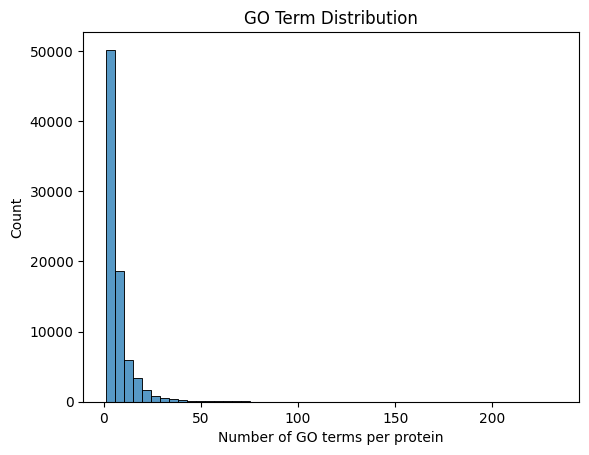

In [10]:
go_counts = train_terms.groupby('EntryID')['term'].count()
sns.histplot(go_counts, bins=50)
plt.xlabel("Number of GO terms per protein")
plt.ylabel("Count")
plt.title("GO Term Distribution")
plt.show()


In [11]:
print("Min length:", np.min(go_counts))
print("Median length:", np.median(go_counts))
print("Mean length:", np.mean(go_counts))
print("95th percentile:", np.percentile(go_counts, 95))
print("Max length:", np.max(go_counts))

# Find the protein with the highest number of GO terms
max_go_count = go_counts.max()
top_proteins = go_counts[go_counts == max_go_count]
print(f"Number of proteins with {max_go_count} GO terms: {len(top_proteins)}")
print(top_proteins)


Min length: 1
Median length: 4.0
Mean length: 6.517001601863988
95th percentile: 20.0
Max length: 233
Number of proteins with 233 GO terms: 1
EntryID
Q02248    233
Name: term, dtype: int64


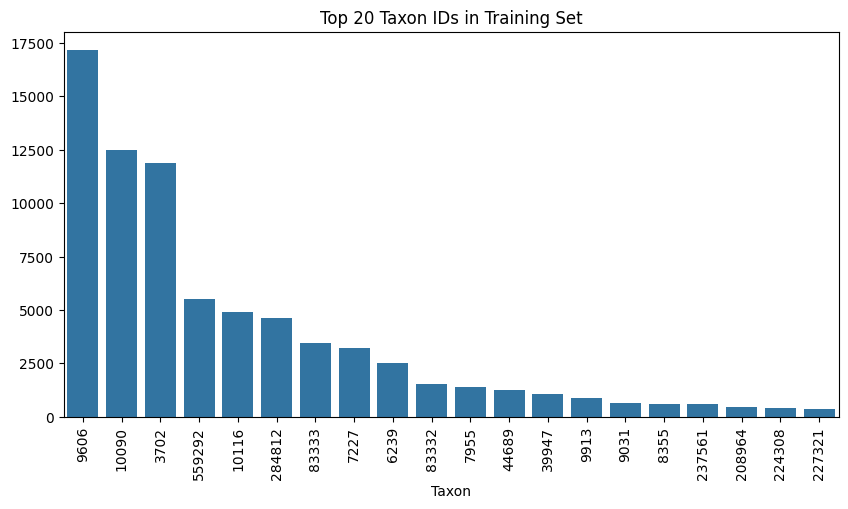

In [12]:
tax_counts = train_taxonomy['Taxon'].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=tax_counts.index.astype(str), y=tax_counts.values)
plt.xticks(rotation=90)
plt.title("Top 20 Taxon IDs in Training Set")
plt.show()


# Feature Extraction

### Amino Acid Distribution

In [13]:
# Compute amino acid composition for first 100 sequences (as demo)
records = list(SeqIO.parse(fasta_path, "fasta"))[:100]

features = []
for record in tqdm(records):
    seq = str(record.seq)
    analysis = ProteinAnalysis(seq)
    aa_freq = analysis.get_amino_acids_percent()
    features.append({
        "id": extract_uniprot_id(record.id),
        "length": len(seq),
        **aa_freq
    })

aa_df = pd.DataFrame(features)
aa_df.head()


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Elaine\miniconda3\envs\deepfri_esm\Lib\site-packages\Bio\SeqUtils\ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(
100%|██████████| 100/100 [00:00<?, ?it/s]


,id,length,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,A0A0C5B5G6,16,0.000000,0.000000,0.000000,0.062500,0.062500,0.062500,0.000000,0.062500,...,0.125000,0.000000,0.062500,0.062500,0.187500,0.000000,0.000000,0.000000,0.062500,0.125000
1,A0JNW5,1464,0.049863,0.017077,0.060109,0.066940,0.035519,0.037568,0.032787,0.057377,...,0.023907,0.053279,0.045765,0.047814,0.034836,0.120902,0.058060,0.056011,0.008197,0.023907
2,A0JP26,581,0.053356,0.037866,0.063683,0.092943,0.015491,0.056799,0.034423,0.036145,...,0.030981,0.060241,0.027539,0.051635,0.049914,0.080895,0.037866,0.046472,0.008606,0.017212
3,A0PK11,232,0.107759,0.021552,0.021552,0.051724,0.064655,0.073276,0.021552,0.081897,...,0.017241,0.025862,0.030172,0.038793,0.025862,0.056034,0.030172,0.107759,0.021552,0.025862
4,A1A4S6,786,0.058524,0.013995,0.047074,0.090331,0.053435,0.049618,0.026718,0.045802,...,0.022901,0.044529,0.063613,0.043257,0.055980,0.080153,0.053435,0.052163,0.008906,0.021628


In [14]:
aa_df.describe().T


,count,mean,std,min,25%,50%,75%,max
length,100.0,552.190000,506.741655,16.000000,251.500000,393.000000,651.250000,2624.000000
A,100.0,0.069425,0.028376,0.000000,0.049162,0.068247,0.084625,0.164977
C,100.0,0.023600,0.023046,0.000000,0.010568,0.019079,0.026857,0.139847
D,100.0,0.046845,0.016378,0.000000,0.037125,0.045602,0.056851,0.100358
E,100.0,0.065139,0.025273,0.013667,0.050252,0.062910,0.078612,0.148485
F,100.0,0.039738,0.021199,0.000000,0.023087,0.038680,0.053477,0.104348
G,100.0,0.069064,0.023779,0.000000,0.051096,0.067117,0.079861,0.142336
H,100.0,0.024910,0.011073,0.000000,0.018071,0.024264,0.031806,0.059259
I,100.0,0.046547,0.020702,0.006645,0.033545,0.045247,0.058729,0.113895
K,100.0,0.055267,0.023638,0.008696,0.039383,0.054300,0.071051,0.148936


### Correlation between Sequence Length & Go Terms

In [15]:
# 1️⃣ Build a DataFrame for sequence lengths
seq_data = []
for record in SeqIO.parse(fasta_path, "fasta"):
    seq_data.append({"EntryID": extract_uniprot_id(record.id), "SeqLength": len(record.seq)})

seq_df = pd.DataFrame(seq_data)

# 2️⃣ Convert GO counts to a DataFrame
go_count_df = go_counts.reset_index()
go_count_df.columns = ["EntryID", "GO_Count"]

# 3️⃣ Merge them together
merged_df = pd.merge(seq_df, go_count_df, on="EntryID", how="inner")

print("Merged shape:", merged_df.shape)
merged_df.head()

Merged shape: (82404, 3)


,EntryID,SeqLength,GO_Count
0,A0A0C5B5G6,16,14
1,A0JNW5,1464,8
2,A0JP26,581,1
3,A0PK11,232,2
4,A1A4S6,786,5


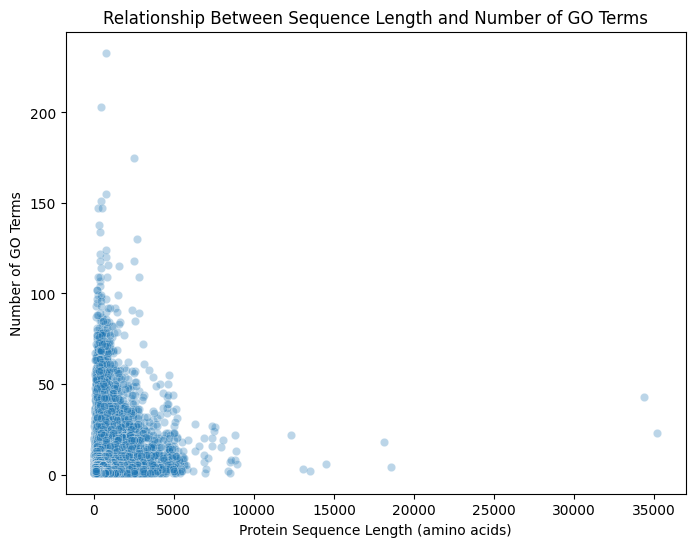

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="SeqLength", y="GO_Count", data=merged_df, alpha=0.3)
plt.xlabel("Protein Sequence Length (amino acids)")
plt.ylabel("Number of GO Terms")
plt.title("Relationship Between Sequence Length and Number of GO Terms")
plt.show()

In [17]:
pearson_corr = merged_df["SeqLength"].corr(merged_df["GO_Count"], method="pearson")
spearman_corr = merged_df["SeqLength"].corr(merged_df["GO_Count"], method="spearman")

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")


Pearson correlation: 0.139
Spearman correlation: 0.182


- Longer proteins tend to have slightly more GO annotations, but the relationship is weak.

- Most proteins are relatively short (a few hundred amino acids) and annotated with only a handful of GO terms.

- Some large, multifunctional proteins (like chaperones or large enzymes) do have many GO terms, but they’re rare and not enough to produce a strong correlation.

- The small positive Spearman correlation suggests that as sequence length increases, the rank of GO term count also tends to increase slightly — consistent with multi-domain or complex proteins having more diverse functions.

# Gene Ontology Analysis

In [18]:
go = GODag(os.path.join(TRAIN_DIR, "go-basic.obo"))
print(f"Number of GO terms parsed: {len(go)}")


./cafa-6-protein-function-prediction\Train\go-basic.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms
Number of GO terms parsed: 43448


In [19]:
# Count categories (BP, MF, CC)
from collections import Counter
aspect_counts = Counter(term.namespace for term in go.values())
aspect_counts

Counter({'biological_process': 27975,
         'molecular_function': 11204,
         'cellular_component': 4269})

### Distribution of GO Term Counts per Taxonomy, Grouped by GO Aspect (Top 10 Taxonomies)

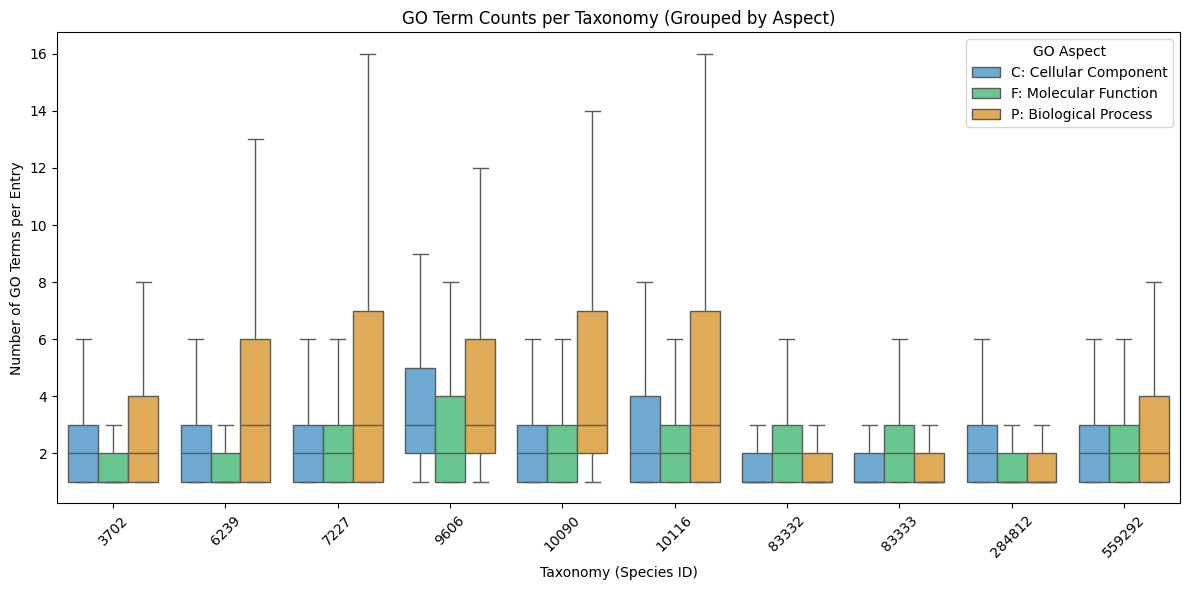

In [20]:
# Count number of unique GO terms per Entry, grouped by aspect
# This calculates how many GO terms each protein has in each aspect type (C, F, P)
go_counts_aspect = train_terms.groupby(['EntryID', 'aspect'])['term'].nunique().reset_index()
go_counts_aspect.rename(columns={'term': 'GO_count'}, inplace=True)

# Merge with taxonomy information to know which species each protein belongs to
merged_df_aspect = pd.merge(go_counts_aspect, train_taxonomy, on='EntryID', how='left')

# Focus on the top 10 most common taxonomies (to keep the plot readable)
top_taxa = merged_df_aspect['Taxon'].value_counts().nlargest(10).index
subset = merged_df_aspect[merged_df_aspect['Taxon'].isin(top_taxa)]

# Define custom color palette for each GO aspect
# You can adjust the hex codes if you prefer different colors
custom_palette = {
    'C': '#5DADE2',   # Blue  → Cellular Component
    'F': '#58D68D',   # Green → Molecular Function
    'P': '#F5B041'    # Orange → Biological Process
}

# Create a grouped box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=subset,
    x='Taxon',
    y='GO_count',
    hue='aspect',
    hue_order=['C', 'F', 'P'],      # ensure consistent color order
    showfliers=False,               # hide outliers for cleaner view
    palette=custom_palette          # apply custom colors
)

# Fix legend colors and labels (must be called AFTER plotting)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles,
    ['C: Cellular Component', 'F: Molecular Function', 'P: Biological Process'],
    title='GO Aspect'
)

# Improve plot readability
plt.xticks(rotation=45)
plt.xlabel('Taxonomy (Species ID)')
plt.ylabel('Number of GO Terms per Entry')
plt.title('GO Term Counts per Taxonomy (Grouped by Aspect)')
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
# Count unique GO terms per EntryID
go_counts_total = (
    train_terms.groupby('EntryID')['term']
    .nunique()
    .reset_index()
    .rename(columns={'term': 'GO_count'})
)

# Protein with the most GO terms
top_protein = go_counts_total.sort_values('GO_count', ascending=False).head(1)
print(f"Top Protein:\n{top_protein}\n")

go_counts_aspect = (
    train_terms.groupby(['EntryID', 'aspect'])['term']
    .nunique()
    .reset_index()
    .rename(columns={'term': 'GO_count'})
)

# Find max protein in each aspect
top_per_aspect = (
    go_counts_aspect.sort_values(['aspect','GO_count'], ascending=[True, False])
    .groupby('aspect')
    .head(1)
)

print(f"Top per aspect:\n{top_per_aspect}")

Top Protein:
      EntryID  GO_count
36932  Q02248       233

Top per aspect:
       EntryID aspect  GO_count
29529   P05067      C        41
29180   P04637      F        34
107551  Q62226      P       188


In [22]:
def load_fasta_sequences(file_path):
    """Return dict {protein_id: sequence}"""
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        prot_id = record.id.split("|")[1] if "|" in record.id else record.id
        sequences[prot_id] = str(record.seq)
    return sequences

train_sequences = load_fasta_sequences(f"{TRAIN_DIR}/train_sequences.fasta")
test_sequences = load_fasta_sequences(f"{TEST_DIR}/testsuperset.fasta")

print(f"Train sequences: {len(train_sequences)}")
print(f"Test superset sequences: {len(test_sequences)}")


Train sequences: 82404
Test superset sequences: 224309


In [23]:
def plot_aa_distribution(aa_dist, protein_id=""):
    # Convert to sorted DataFrame
    df = pd.DataFrame({
        "AA": list(aa_dist.keys()),
        "Frequency": list(aa_dist.values())
    }).sort_values("AA")   # alphabetical order

    plt.figure(figsize=(10, 4))
    sns.barplot(data=df, x="AA", y="Frequency")
    plt.title(f"Amino Acid Distribution for {protein_id}")
    plt.ylabel("Fraction")
    plt.xlabel("Amino Acid")
    plt.tight_layout()
    plt.show()

In [24]:
go_dag = GODag(f"{TRAIN_DIR}/go-basic.obo")
def lookup_go_name(go_id):
        return go_dag[go_id].name if go_id in go_dag else None

./cafa-6-protein-function-prediction\Train/go-basic.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms


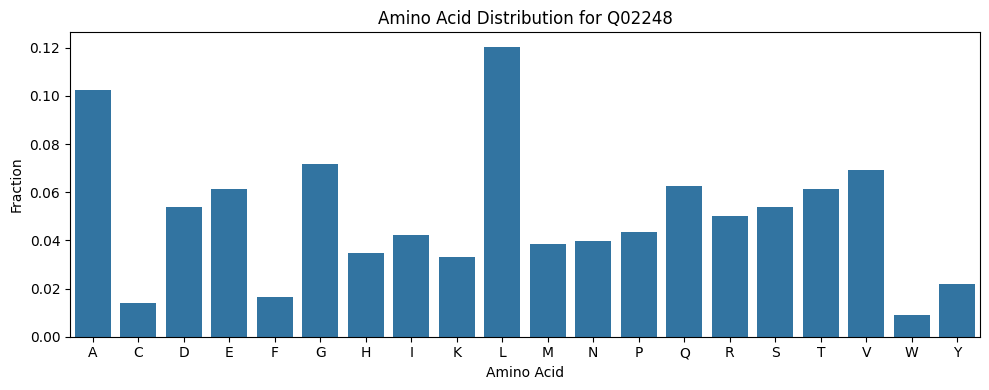

{'Taxo': 10090,
 'total_GO_terms': 233,
 'GO_terms_by_aspect': {'C': 38, 'F': 16, 'P': 179},
 'GO_terms_full':               term                                            GO_name aspect
 471973  GO:0048643  positive regulation of skeletal muscle tissue ...      P
 471974  GO:0060070                    canonical Wnt signaling pathway      P
 471975  GO:0005634                                            nucleus      C
 471976  GO:0005829                                            cytosol      C
 471977  GO:0016020                                           membrane      C
 ...            ...                                                ...    ...
 472201  GO:0099092      postsynaptic density, intracellular component      C
 472202  GO:0098831      presynaptic active zone cytoplasmic component      C
 472203  GO:0042734                               presynaptic membrane      C
 472204  GO:0045211                              postsynaptic membrane      C
 472205  GO:0097091             

In [25]:
def analyze_proteiin(protein_id):
    results = {}
    taxonomy = train_taxonomy[train_taxonomy['EntryID'] == protein_id]['Taxon']
    results['Taxo'] = taxonomy.values[0] if not taxonomy.empty else None
    go_terms = train_terms[train_terms["EntryID"] == protein_id].copy()
    results["total_GO_terms"] = go_terms["term"].nunique()
    # Count per aspect
    go_counts_aspect = (
        go_terms.groupby("aspect")["term"]
        .nunique()
        .reindex(["C", "F", "P"], fill_value=0)
        .to_dict()
    )
    results["GO_terms_by_aspect"] = go_counts_aspect
    go_terms["GO_name"] = go_terms["term"].apply(lookup_go_name)
    results["GO_terms_full"] = go_terms[["term", "GO_name", "aspect"]]
    seq = train_sequences[protein_id]

    if seq is None:
        dis = []
    else:
        aa_counts = pd.Series(list(seq)).value_counts(normalize=True)
        dis = aa_counts.to_dict()
    plot_aa_distribution(dis, protein_id=protein_id)
    return results

analyze_proteiin('Q02248')

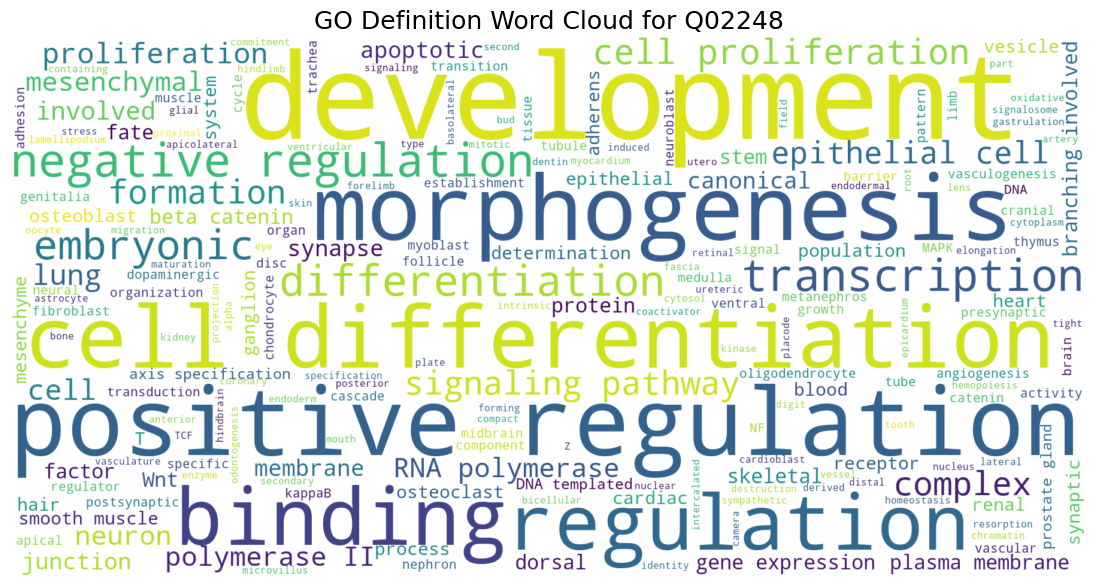

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_go_definition_wordcloud(protein_id):
    # Extract GO terms for the protein
    go_terms = train_terms[train_terms["EntryID"] == protein_id]["term"].unique()

    # Extract definitions
    definitions = [lookup_go_name(go_id) for go_id in go_terms]
    # Remove None values
    definitions = [d for d in definitions if d is not None]

    # Combine into one large text string
    text = " ".join(definitions)

    # Generate word cloud
    wc = WordCloud(
        width=1800,
        height=900,
        background_color="white",
        collocations=True,
        max_words=200
    ).generate(text)

    # Plot
    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"GO Definition Word Cloud for {protein_id}", fontsize=18)
    plt.show()
plot_go_definition_wordcloud("Q02248")

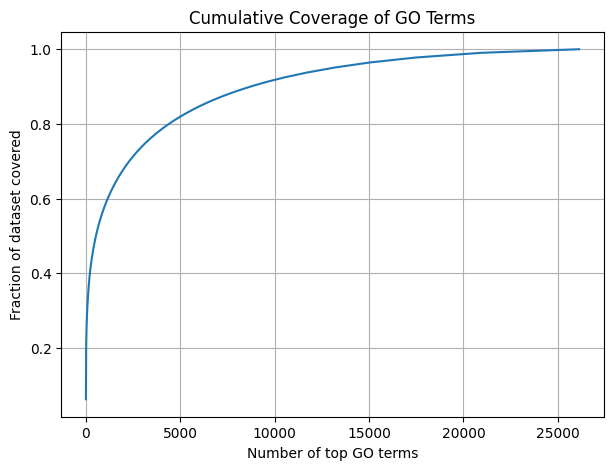

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load training GO annotations
df = pd.read_csv(f"{TRAIN_DIR}/train_terms.tsv", sep="\t")

# Count frequency of each GO term
freq = df["term"].value_counts()

# Sort (value_counts() already sorts descending)
go_terms_sorted = freq.index
counts_sorted = freq.values

# Compute cumulative coverage
cumulative_counts = np.cumsum(counts_sorted)
total_annotations = cumulative_counts[-1]
coverage = cumulative_counts / total_annotations

# Plot
plt.figure(figsize=(7,5))
plt.plot(range(1, len(coverage)+1), coverage)
plt.xlabel("Number of top GO terms")
plt.ylabel("Fraction of dataset covered")
plt.title("Cumulative Coverage of GO Terms")
plt.grid(True)
plt.show()


In [29]:
k = 5000
print("Coverage for top 5000 GO terms = ", coverage[k-1])


Coverage for top 5000 GO terms =  0.8195714554389258


In the CAFA training dataset, GO annotations follow a long-tail distribution: a very small number of GO terms appear extremely frequently across proteins, while thousands of GO terms appear only once or twice.
To quantify this effect, we computed the cumulative coverage of GO terms ranked by frequency. The analysis shows:
- The top 5000 most frequent GO terms cover ~80% of all GO annotations in the training set.
- The remaining ~20,000+ GO terms each appear only a few times and contribute very little to overall coverage.

Including all ~26,000 GO terms would dramatically expand the output dimension while adding mostly sparse, noisy labels that hurt model training.

In [30]:
cutoff = 5000
subset = freq.head(cutoff).index.tolist()
df_top = df[df["term"].isin(subset)]
# Pivot into a binary matrix: rows=EntryID, columns=GO, value=1 if present
binary_df = (
    df_top
    .assign(value=1)
    .pivot_table(index="EntryID", columns="term", values="value", fill_value=0)
)
for go in subset:
    if go not in binary_df.columns:
        binary_df[go] = 0

binary_df = binary_df[subset]

print("Matrix shape:", binary_df.shape)
binary_df.head()

labels = binary_df.to_numpy().astype(np.float32)
entry_ids = binary_df.index.to_numpy()
go_terms = binary_df.columns.to_numpy()

np.save(f"train_labels_top{cutoff}.npy", labels)
np.save("train_entry_ids.npy", entry_ids)
np.save(f"go_terms_top{cutoff}.npy", go_terms)

print("Saved label matrix + entry IDs + GO terms.")


Matrix shape: (80058, 5000)
Saved label matrix + entry IDs + GO terms.


In [31]:
train_ids = set(train_sequences.keys())
test_ids = set(test_sequences.keys())

overlap = train_ids.intersection(test_ids)

print("Number of overlapping proteins:", len(overlap))

if len(overlap) > 0:
    print("Examples:", list(overlap)[:10])
else:
    print("✅ No overlaps — test set does not contain train proteins.")


Number of overlapping proteins: 82404
Examples: ['Q9XYM0', 'Q10161', 'Q4R1C4', 'O23482', 'Q9NQZ8', 'Q92523', 'P52842', 'Q3UBX0', 'Q9FMX8', 'Q96A72']


The test superset contains all proteins from the training set.